# Loading the data and required libraries

In [2]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
# from google.colab import drive 

import string
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, GRU
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils.vis_utils import plot_model

import tensorflow as tf

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
DIR = "E:/Coding/Summer 2023/data/"

In [5]:
adm_notes = pd.read_csv(DIR + "readmission.csv", low_memory=False)

# Natural Language

In [6]:
def clean_text(texts):
    texts = texts.fillna(' ')
    texts = texts.str.replace('\n',' ')
    texts = texts.str.replace('\r',' ')

    table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower().translate(table) for text in texts]

    return texts

In [7]:
adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

In [8]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['patient', 'date', 'admission', 'discharge', 'lastname', 'firstname', 'sex']

In [9]:
porter = PorterStemmer()

In [10]:
def tokenize_stem(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [porter.stem(word) for word in words]
    return words

In [11]:
for i, text in enumerate(adm_notes['TEXT']):
   adm_notes.loc[i, 'TEXT'] = (' ').join(tokenize_stem(adm_notes['TEXT'][i]))

# Model
## Words, Train and Test

Repartition data

In [12]:
df_train, df_test = train_test_split(adm_notes, test_size=0.2, random_state=42)

Subsample non-readmitted patients to match size of readmitted ones

In [13]:
rows_pos = df_train['READM_WITHIN_30'] == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos))], axis = 0)
df_train = df_train.sample(n = len(df_train)).reset_index(drop = True)

In [14]:
rows_pos = df_test['READM_WITHIN_30'] == 1
df_test_pos = df_test.loc[rows_pos]
df_test_neg = df_test.loc[~rows_pos]

df_test = pd.concat([df_test_pos, df_test_neg.sample(n = len(df_test_pos))], axis = 0)
df_test = df_test.sample(n = len(df_test)).reset_index(drop = True)

In [15]:
print(df_train.shape)
print(df_test.shape)

(4630, 10)
(1296, 10)


Sparse Matrix with word count

# Recurrent Neural Network

In [16]:
NUMBER_WORDS = 5000

tokenizer = Tokenizer(num_words=NUMBER_WORDS)
tokenizer.fit_on_texts(df_train['TEXT'])
sequences_train = tokenizer.texts_to_sequences(df_train['TEXT'])
sequences_test = tokenizer.texts_to_sequences(df_test['TEXT'])

X_train = pad_sequences(sequences_train, maxlen=NUMBER_WORDS)
X_test = pad_sequences(sequences_test, maxlen=NUMBER_WORDS)

In [17]:
y_train = to_categorical(df_train['READM_WITHIN_30'])
y_test = to_categorical(df_test['READM_WITHIN_30'])

In [18]:
adam = Adam(learning_rate=0.0001)

In [19]:
model = Sequential()
model.add(Embedding(X_train.shape[1], 64, input_length=X_train.shape[1] ))
model.add(GRU(64, dropout=0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 64)          320000    
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 345,090
Trainable params: 345,090
Non-trainable params: 0
_________________________________________________________________


In [20]:
plot_model(model, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
history = model.fit(X_train, y_train, epochs = 10, batch_size = 64, validation_split=0.2)

Epoch 1/10
58/58 [==============================] - 417s 7s/step - loss: 0.6929 - accuracy: 0.5119 - val_loss: 0.6919 - val_accuracy: 0.5637
Epoch 2/10
58/58 [==============================] - 408s 7s/step - loss: 0.6915 - accuracy: 0.5375 - val_loss: 0.6909 - val_accuracy: 0.5680
Epoch 3/10
58/58 [==============================] - 409s 7s/step - loss: 0.6906 - accuracy: 0.5486 - val_loss: 0.6895 - val_accuracy: 0.5648
Epoch 4/10
58/58 [==============================] - 408s 7s/step - loss: 0.6889 - accuracy: 0.5613 - val_loss: 0.6881 - val_accuracy: 0.5691
Epoch 5/10
58/58 [==============================] - 410s 7s/step - loss: 0.6871 - accuracy: 0.5756 - val_loss: 0.6866 - val_accuracy: 0.5616
Epoch 6/10
58/58 [==============================] - 409s 7s/step - loss: 0.6849 - accuracy: 0.5745 - val_loss: 0.6849 - val_accuracy: 0.5648
Epoch 7/10
58/58 [==============================] - 413s 7s/step - loss: 0.6830 - accuracy: 0.5856 - val_loss: 0.6836 - val_accuracy: 0.5670
Epoch 8/10
58

In [22]:
print(model.metrics_names)
model.evaluate(X_test, y_test, batch_size=64)

['loss', 'accuracy']
21/21 [==============================] - 24s 1s/step - loss: 0.6812 - accuracy: 0.5687


[0.6811752319335938, 0.5686728358268738]

In [23]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

y_test_raw = df_test['READM_WITHIN_30']

print(classification_report(y_test_raw, y_pred, digits=3))
print(roc_auc_score(y_test_raw, y_pred))

21/21 [==============================] - 26s 1s/step
              precision    recall  f1-score   support

           0      0.567     0.583     0.575       648
           1      0.571     0.554     0.562       648

    accuracy                          0.569      1296
   macro avg      0.569     0.569     0.569      1296
weighted avg      0.569     0.569     0.569      1296

0.5686728395061728


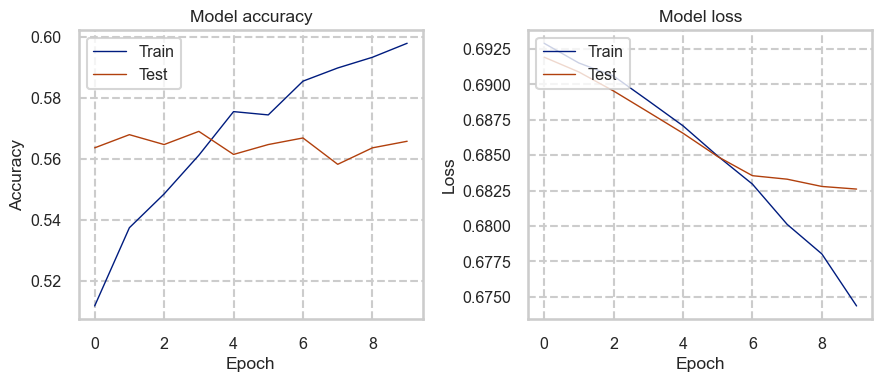

<Figure size 640x480 with 0 Axes>

In [24]:
sns.set('talk', 'whitegrid', 'dark', font_scale=0.7,
        rc={"lines.linewidth": 1, 'grid.linestyle': '--'})

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')

fig.tight_layout()
plt.show()

plt.savefig('fig/gru.pgf')